In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/diabetes.csv", header=0).dropna()

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
X = df.drop(columns=["BMI", "Outcome"], errors="ignore")  # BMI, Outcome 제외
y = df["BMI"].astype(float)

In [5]:
zero_as_missing_candidates = ["Glucose", "BloodPressure", "SkinThickness", "Insulin"]
for col in zero_as_missing_candidates:
    if col in X.columns:
        X.loc[X[col] == 0, col] = np.nan

In [6]:
X = X.fillna(X.median(numeric_only=True))

In [7]:
valid_mask = y > 0
X = X.loc[valid_mask].reset_index(drop=True)
y = y.loc[valid_mask].reset_index(drop=True)

In [8]:
X = X.values
y = y.values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [10]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc   = scaler.transform(X_val)
X_test_sc  = scaler.transform(X_test)

In [11]:
print(f"Train: {X_train_sc.shape}, Val: {X_val_sc.shape}, Test: {X_test_sc.shape}")

Train: (484, 7), Val: (121, 7), Test: (152, 7)


In [12]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_sc.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="linear")  # 회귀
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,345 (36.50 KB)

 Trainable params: 9,345 (36.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
es = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

In [16]:
history = model.fit(
    X_train_sc, y_train,
    validation_data=(X_val_sc, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1063.4247 - mae: 31.8927 - val_loss: 977.4800 - val_mae: 30.4336
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 974.8433 - mae: 30.4312 - val_loss: 837.4647 - val_mae: 28.0444
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 833.0667 - mae: 27.8809 - val_loss: 636.2722 - val_mae: 24.1606
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 597.9617 - mae: 23.3580 - val_loss: 400.7820 - val_mae: 18.5264
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 363.3304 - mae: 17.3996 - val_loss: 196.1128 - val_mae: 12.1922
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 194.2477 - mae: 11.8776 - val_loss: 101.6816 - val_mae: 8.2687
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 109.6127 - mae: 8.5084 - val_loss: 87.0189 - val_mae: 7.7118
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 115.5682 - mae: 8.6029 - val_loss: 80.3290 - val_mae: 7.4061
Epoch 9/300
16/16 ━━━

In [18]:
y_pred = model.predict(X_test_sc, verbose=0).reshape(-1)

mse  = np.mean((y_test - y_pred) ** 2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(y_test - y_pred))
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print("\n=== BMI Regression (Deep Learning) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R^2 : {r2:.4f}")


=== BMI Regression (Deep Learning) ===
RMSE: 5.4229
MAE : 4.3071
R^2 : 0.2757


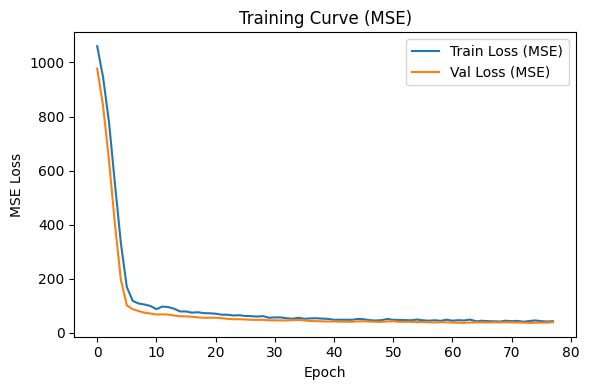

In [24]:
# 학습/검증 손실 곡선
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training Curve (MSE)")
plt.legend(); plt.tight_layout(); plt.show()

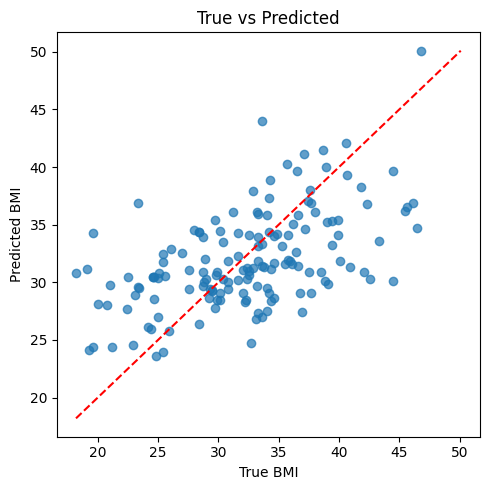

In [20]:
# y_true vs y_pred 산점도
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.7)
min_v, max_v = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--')
plt.xlabel("True BMI"); plt.ylabel("Predicted BMI"); plt.title("True vs Predicted")
plt.tight_layout(); plt.show()

In [21]:
idx = 0
sample = X_test_sc[idx:idx+1]
pred_bmi = model.predict(sample, verbose=0)[0,0]
print(f"\nSample #{idx} -> Pred: {pred_bmi:.2f}, True: {y_test[idx]:.2f}")



Sample #0 -> Pred: 40.30, True: 35.70
